# Prelude

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import pandas
import numpy
import itertools
import matplotlib
import seaborn
import textwrap

from matplotlib.ticker import *

from matplotlib import pyplot
from matplotlib.ticker import FixedLocator, AutoLocator, FuncFormatter, MultipleLocator, IndexLocator, MaxNLocator

from pandas import Series, DataFrame, Index

seaborn.set()

In [2]:
from scipy import stats

# Getting Data

In [3]:
llama = pandas.read_csv('outputs/llama.csv', index_col = 'Num')
llama.name = 'llama-3.1-8B'

bigllama = pandas.read_csv('outputs/llama-70b.csv', index_col = 'Num').rename(columns = lambda x: x.split('-')[0])
bigllama.name = 'llama-3.1-70B'

In [4]:
flan = pandas.read_csv('outputs/flan-t5-xl.csv', index_col = 'Num')
flan.name = 'flan-t5-xl'

bigflan = pandas.read_csv('outputs/flan-t5-xxl.csv', index_col = 'Num')
bigflan.name = 'flan-t5-xxl'

# Plotting Functions

In [5]:
def cool_line(left, right, ax = None, cleft = None, cright = None, **kwargs):
    if ax is None:
        ax = pyplot.gca()

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['[]', '[ctx]'])
    # ax.set_ylim(0 - .05, 1 + .05)

    kwargs['alpha'] = .75
    kwargs['color'] = cleft or kwargs['color']
    kwargs['zorder'] = zorders[kwargs['color']]
    ax.scatter([0], [left], **kwargs)

    kwargs['color'] = cright or kwargs['color']
    kwargs['zorder'] = zorders[kwargs['color']]
    ax.scatter([1], [right], **kwargs)

    kwargs['color'] = 'black'
    kwargs['alpha'] = 1
    kwargs['linewidth'] = .2
    kwargs['zorder'] = 1
    ax.plot([0, 1], [left, right], **kwargs)

In [6]:
palette = seaborn.color_palette('hls', 3)
colors = {
    'Parametric': palette[1],
    'Contextual': palette[0],
    'Other': palette[2],
}
zorders = {
    colors['Parametric']: 5,
    colors['Contextual']: 4,
    colors['Other']: 6,
}

pcolors = {
    'Parametric': palette[1],
    'Contextual': palette[0],
}

dark_palette = seaborn.color_palette('dark', 3)
dark_colors = {
    'Parametric': dark_palette[2],
    'Contextual': dark_palette[1],
    'Other': dark_palette[0],
}
dark_pcolors = {
    'Parametric': dark_palette[2],
    'Contextual': dark_palette[1],
}

all_colors = [colors, dark_colors]
all_pcolors = [pcolors, dark_pcolors]

def getPlots(table, title = None, axs = None):
    if axs is None:
        fig, axs = pyplot.subplots(
            ncols = 3,
            squeeze = True,
            sharey = True,
        )
        if title:
            fig.suptitle(title, fontsize = 12)

    top = 0
    bot = 100

    for _, row in table.iterrows():
        cright = colors[row.comparison]

        base_proba = row.base_proba
        base_cf_proba = row.base_cf_proba
        ctx_proba = row.ctx_proba
        ctx_param_proba = row.ctx_param_proba
        ctx_cf_proba = row.ctx_cf_proba

        cool_line(base_proba, ctx_param_proba, axs[0], color = colors['Parametric'])
        # cool_line(base_proba, ctx_proba, axs[1], cleft = colors['Parametric'], cright = cright)
        cool_line(base_cf_proba, ctx_cf_proba, axs[1], color = colors['Counterfactual'])

        filt = lambda p: filter(lambda x: x < 100, p)
        top = max(top, *filt([base_proba, base_cf_proba, ctx_proba, ctx_param_proba, ctx_cf_proba]))
        bot = min(bot, *filt([base_proba, base_cf_proba, ctx_proba, ctx_param_proba, ctx_cf_proba]))

    axs[0].set_ylabel('Cross-Entropy', fontsize = 9)
    axs[0].set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)
    axs[1].set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)
    # for ax in axs:
        # ax.set_ylim(bot - (top - bot) * .04, top + (top - bot) * .04)

In [7]:
def barTable(*tables, names = None):
    if names is None:
        names = [t.name for t in tables]
    assert len(names) == len(tables)

    datas = []
    for e, (t, n) in enumerate(zip(tables, names)):
        datas.append(Series(
            {x: sum(t.comparison == x) for x in colors.keys()},
            name = n,
        ))

    return pandas.concat(datas, axis = 1).T

def barPlot(*tables, ax = None, names = None, percent = False, show_ylabel = True):
    if ax is None:
        pyplot.figure()
        ax = pyplot.gca()

    if names is None:
        names = [t.name for t in tables]
    assert len(names) == len(tables)

    tab = .8 * (1 / len(tables))
    for e, (t, n) in enumerate(zip(tables, names)):
        data = [sum(t.comparison == x) for x in colors.keys()]
        if percent:
            data = [x / t.index.size for x in data]

        ax.bar(
            [x + e * tab for x in range(3)],
            data,
            width = tab,
            align = 'edge',
            color = all_colors[e].values(),
            tick_label = colors.keys(),
            label = [n, ' ', ' '],
        )

    if percent:
        # ax.set_ylabel('Ratio of results')
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
        ax.tick_params(axis='both', which='major', labelsize = 9, pad = -3)
    else:
        if show_ylabel:
            ax.set_ylabel('Resulting Entries', fontsize = 10)
        ax.tick_params(axis='both', which='major', labelsize = 10, pad = -3)
        ax.set_ylim(0, tables[0].shape[0])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles[0::3] + handles[1::3] + handles[2::3],
            labels[0::3] + labels[1::3] + labels[2::3],
            ncols = 3,
            fontsize = 'small',
            markerfirst = False,
            columnspacing = 0,
        )


In [8]:
def boxTable(*tables, names = None, percent = False):
    if names is None:
        names = [t.name for t in tables]
    assert(len(names) == len(tables))

    results = []
    for e, (t, n) in enumerate(zip(tables, names)):
        to_drop = ['min', 'max']
        results.append(
            t \
            .groupby('preference') \
            .ctx_proba \
            .describe() \
            .T \
            .drop(to_drop, axis = 0)[pcolors.keys()]
        )

    return pandas.concat(results, keys = names, axis = 1)

def boxPlot(*tables, ax = None, names = None, percent = None):
    if ax is None:
        pyplot.figure()
        ax = pyplot.gca()

    if names is None:
        names = [t.name for t in tables]
    assert(len(names) == len(tables))

    tab = .8 * (1 / len(tables))
    for e, (t, n) in enumerate(zip(tables, names)):
        plot = ax.boxplot(
            [t[t.preference == x].ctx_proba for x in pcolors.keys()],
            positions = [x + e * tab for x in range(2)],
            widths = tab,
            showfliers = False,
            patch_artist = True,
            label = [n, ' '],
        )
        for p, c in zip(plot['boxes'], all_pcolors[e].values()):
            p.set_facecolor(c)

    ax.set_ylabel('Perplexity', fontsize = 9)
    # ax.set_ylim(.25, None)
    ax.set_xticks([x + 1/4 * len(tables) * tab for x in range(2)], labels = pcolors.keys())

    ax.yaxis.set_major_locator(MaxNLocator(5, min_n_ticks = 5))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

    if percent:
        ax.tick_params(axis='both', which='major', labelsize = 9, pad = -3)

    handles, labels = pyplot.gca().get_legend_handles_labels()
    ax.legend(
        handles[0::2] + handles[1::2],
        labels[0::2] + labels[1::2],
        ncols = 2,
        fontsize = 'small',
        markerfirst = False,
        columnspacing = 0,
    )

In [9]:
def avgPlots(table):
    for e, (k, v) in enumerate(colors.items()):
        p = llama[llama.comparison == k].groupby('Category').ctx_proba.mean().sort_index()
        pyplot.bar(
            [e * (p.shape[0] + 1) + x for x in range(p.shape[0])],
            p,
            color = v,
            align = 'edge',
            width = 1,
        )

In [10]:
def generateTables(*tables, head = None):
    for question, table in itertools.islice(tables[0].groupby('Base_Question'), head):
        ix = table.index

        fig, axs = pyplot.subplots(ncols = 4, nrows = len(tables), width_ratios = [1, 1, 1.5, 2], squeeze = False, figsize = (10, 3 * len(tables)))
        fig.tight_layout(rect = [0, .05, 1, .97])
        fig.suptitle(question, fontsize = 12)

        for e, df in enumerate(tables):
            df_part = df.loc[ix]
            getPlots(df_part, axs = axs[e][0:2])
            boxPlot(df_part, ax = axs[e][2])
            barPlot(df_part, ax = axs[e][3])

        for name, color in colors.items():
            pyplot.scatter([], [], label = name, color = color)

        pyplot.legend(ncols = 3, bbox_to_anchor = [0, -.2])
        pyplot.show()

In [11]:
def cat_subplots(*tables, table_func, plot_func, ymax = None):
    fig, axs = pyplot.subplots(
        5,
        2,
        figsize = (2 * 4, 5 * 2.2),
        sharey = True,
    )
    axs = list(itertools.chain.from_iterable(axs))

    results = []
    for cat, ax in zip(tables[0].Category.unique(), axs):
        thiscat = [
            t[t.Category == cat]
            for t in tables
        ]
        names = [t.name for t in tables]

        if table_func is not None:
            results.append(table_func(*thiscat, names = names).stack().rename(cat))

        plot_func(
            *thiscat,
            names = names,
            ax = ax,
            percent = True,
        )
        ax.set_title(cat.title().replace('_', ' '), fontsize = 10, fontweight = 'bold', pad = 3)
        if ymax is not None:
            ax.set_ylim(2 / ymax, ymax)

        ax.tick_params(axis = 'y', labelleft = True)

    fig.delaxes(axs[9])
    handles, labels = axs[0].get_legend_handles_labels()
    n = len(handles) // 2
    fig.legend(
        itertools.chain.from_iterable(handles[x::n] for x in range(n)),
        itertools.chain.from_iterable(labels[x::n] for x in range(n)),
        ncols = n,
        markerfirst = False,
        columnspacing = 0,
        loc = 'lower right',
        bbox_to_anchor = (.89, .13),
        title = 'Models',
    )
    pyplot.subplots_adjust(hspace = .32)

    if results:
        display(pandas.concat(results, axis = 1).T)


# Plotting Data

## Amount barplots

In [12]:
matplotlib.rcParams['figure.figsize'] = 5, 3

,Parametric,Contextual,Other
llama-3.1-8B,7586,36730,3284
llama-3.1-70B,10869,32727,4004


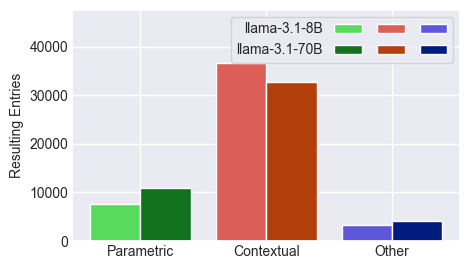

In [13]:
display(barTable(llama, bigllama))
barPlot(llama, bigllama)
pyplot.savefig('Report/figures/llama_amount.png', dpi = 200, bbox_inches = 'tight')

,Parametric,Contextual,Other
flan-t5-xl,2146,43018,2436
flan-t5-xxl,2419,43155,2026


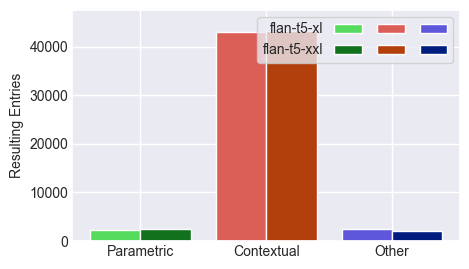

In [14]:
display(barTable(flan, bigflan))
barPlot(flan, bigflan)
pyplot.savefig('Report/figures/flan_amount.png', dpi = 200, bbox_inches = 'tight')

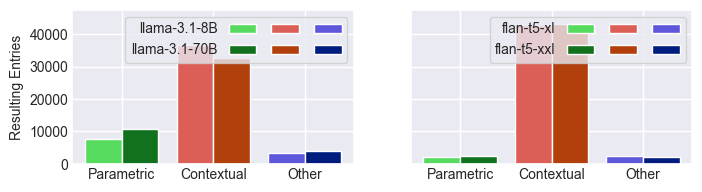

In [15]:
fig, axs = pyplot.subplots(1, 2, figsize = (8, 2), squeeze = True, sharey = True)
barPlot(llama, bigllama, ax = axs[0])
barPlot(flan, bigflan, ax = axs[1], show_ylabel = False)
pyplot.savefig('Report/figures/both_amount.png', dpi = 200, bbox_inches = 'tight')

llama-3.1-8B                  llama-3.1-70B                 
                   Parametric Contextual Other    Parametric Contextual Other
person                    408       8408   874          1961       6237  1492
city                     1237       9998   665          1691       9541   668
principle                 491       1173   186           493       1124   233
element                  2255       3756   439          2823       3402   225
book                     1329       3596   465          1697       3066   627
painting                  474       4555   251           493       4473   314
historical_event          791       1573   196          1082       1215   263
building                  241       1647    92           325       1556    99
composition               360       2024   116           304       2113    83

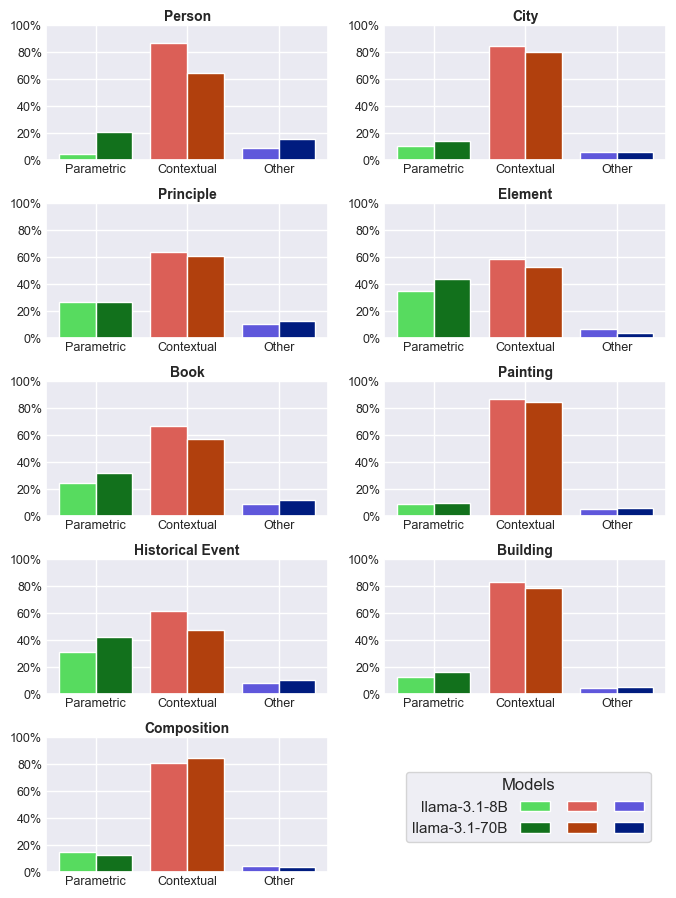

In [16]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(llama, bigllama, table_func = barTable, plot_func = barPlot)
pyplot.savefig('Report/figures/llama_allcats.png', dpi = 200, bbox_inches = 'tight')

flan-t5-xl                  flan-t5-xxl                 
                 Parametric Contextual Other  Parametric Contextual Other
person                  295       8930   465         160       9065   465
city                   1152      10386   362         772      10995   133
principle               133       1649    68          51       1727    72
element                  14       6394    42        1042       5171   237
book                    183       4901   306         186       4516   688
painting                205       4531   544          89       4876   315
historical_event         63       2226   271          13       2535    12
building                 94       1795    91          19       1886    75
composition               7       2206   287          87       2384    29

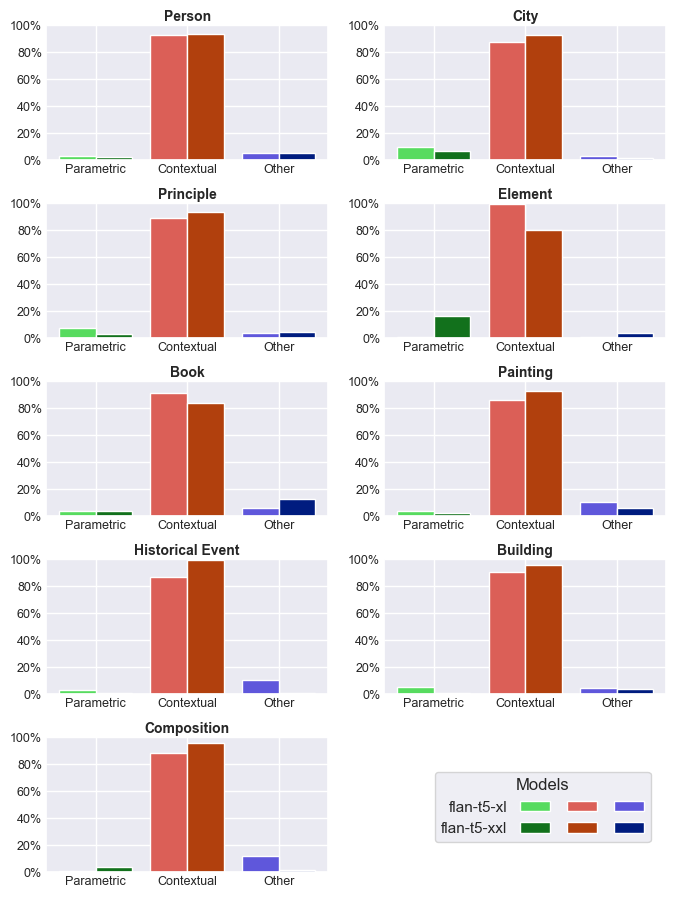

In [17]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(flan, bigflan, table_func = barTable, plot_func = barPlot)
pyplot.savefig('Report/figures/flan_allcats.png', dpi = 200, bbox_inches = 'tight')

## Boxplots

In [18]:
display(boxTable(llama, bigllama))
display(boxTable(flan, bigflan))

llama-3.1-8B               llama-3.1-70B              
preference   Parametric    Contextual    Parametric    Contextual
count       2917.000000  44683.000000   3813.000000  43787.000000
mean           1.663613      1.197617      1.556568      1.228459
std            0.664115      0.280874      0.457214      0.322992
25%            1.291795      1.053240      1.285618      1.067031
50%            1.455134      1.109965      1.420819      1.124843
75%            1.784344      1.229049      1.651478      1.259311

flan-t5-xl                flan-t5-xxl              
preference   Parametric    Contextual   Parametric    Contextual
count       6289.000000  41311.000000  5062.000000  42538.000000
mean           6.552620      1.564700    12.015559      1.275548
std           10.523387      0.577059    19.270086      0.795424
25%            3.203125      1.195312     2.484375      1.023438
50%            4.656250      1.382812     4.031250      1.085938
75%            7.093750      1.703125     7.890625      1.226562

In [19]:
matplotlib.rcParams['figure.figsize'] = 5, 3

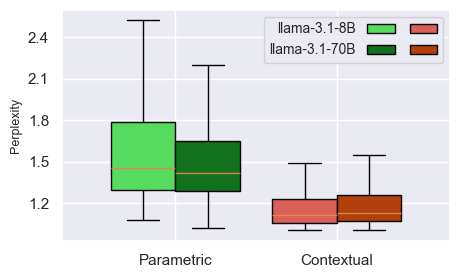

In [20]:
boxPlot(llama, bigllama)
pyplot.savefig('Report/figures/llama_boxplot.png', dpi = 200, bbox_inches = 'tight')

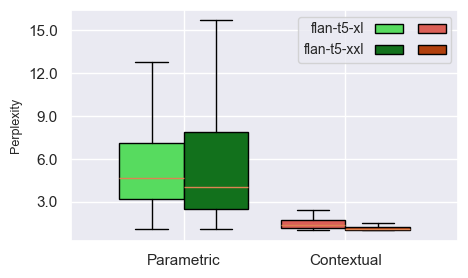

In [21]:
boxPlot(flan, bigflan)
pyplot.savefig('Report/figures/flan_boxplot.png', dpi = 200, bbox_inches = 'tight')

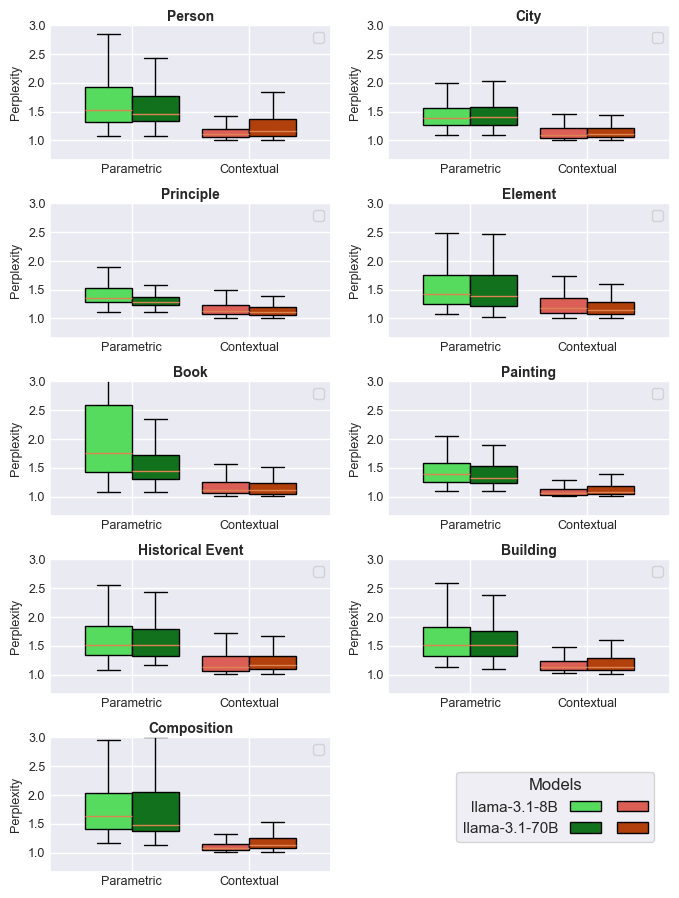

In [22]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(llama, bigllama, table_func = None, plot_func = boxPlot, ymax = 3)
pyplot.savefig('Report/figures/llama_catboxes.png', dpi = 200, bbox_inches = 'tight')

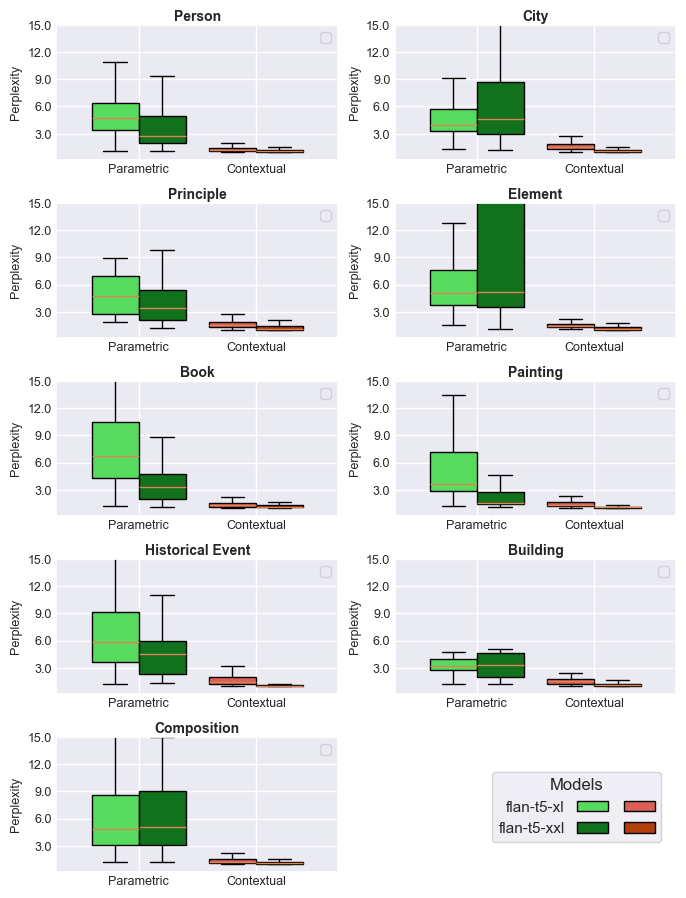

In [23]:
matplotlib.rcParams['figure.figsize'] = 4, 2

cat_subplots(flan, bigflan, table_func = None, plot_func = boxPlot, ymax = 15)
pyplot.savefig('Report/figures/flan_catboxes.png', dpi = 200, bbox_inches = 'tight')

# Analysing Others

In [24]:
pandas.concat(
    [
        flan.comparison.value_counts().rename(flan.name),
        bigflan.comparison.value_counts().rename(bigflan.name),
        llama.comparison.value_counts().rename(llama.name),
        bigllama.comparison.value_counts().rename(bigllama.name),
    ],
    axis = 1,
)

,flan-t5-xl,flan-t5-xxl,llama-3.1-8B,llama-3.1-70B
comparison,,,,
Contextual,43018,43155,36730,32727
Other,2436,2026,3284,4004
Parametric,2146,2419,7586,10869


In [25]:
pandas.crosstab(llama.comparison.rename('llama'), bigllama.comparison.rename('bigllama'))

bigllama,Contextual,Other,Parametric
llama,,,
Contextual,27022,2863,6845
Other,1798,560,926
Parametric,3907,581,3098


In [26]:
pandas.crosstab(flan.comparison.rename('flan'), bigflan.comparison.rename('bigflan'))

bigflan,Contextual,Other,Parametric
flan,,,
Contextual,38928,1829,2261
Other,2239,120,77
Parametric,1988,77,81


In [27]:
pandas.options.display.max_colwidth = 1000
pandas.options.display.max_rows = 1000

In [28]:
llama[llama.comparison == 'Other'][['Question', 'parametric', 'counterfactual', 'contextual']].sample(100)

,Question,parametric,counterfactual,contextual
Num,,,,
30050,Q: Who's the author of One Hundred Years of Solitude?,Gabriel Garcia Marquez,the Russian novelist Leo Tolstoy,the Colombian novelist Gabriel Garcia Marquez
8627,Q: What was Leonardo da Vinci's preferred artistic or scientific medium?,oil painting,music,painting
46270,Q: What is the opus number of The Blue Danube?,Op,67,314
974,Q: In what city was Billie Jean King born?,"Long Beach, California","the city of Luoyang, which is located in the Henan province of China","the city of Long Beach, California, USA"
18786,Q: What is the most famous landmark in Rio de Janeiro?,"the Christ the Redeemer statue, which is a massive Art Deco statue of Jesus Christ that overlook","the Shwedagon Pagoda, a 326-foot-tall golden stupa that is considered one","the Christ the Redeemer statue, a 98-foot-tall Art Deco statue of Jesus Christ"
34924,Q: How many pages are in To Kill a Mockingbird?,281 pages in the hardcover edition,"1,215 pages in the Modern Library edition",281 pages in the Modern Library edition
12745,Q: What is the time zone of Sydney?,AEST (Australian Eastern Standard Time) which is UTC+10,UTC+4,UTC+10
1306,Q: What is the date of death of Marcus Aurelius?,180 AD,"March 27, 1968","March 27, 180 AD"
25002,Q: What is the melting point of Lead?,327,-111,-33


In [38]:
others = Out[32]
others

,Question,parametric,counterfactual,contextual
Num,,,,
41500,Q: Who was the primary leader associated with The Reforms of Diocletian?,Diocletian himself,"Caracalla, a Roman Emperor","Diocletian, a Roman Emperor"
27828,Q: What's the primary isotope of Bismuth?,209Bi,Argon-40,Bismuth-209
29272,Q: In which period of the periodic table is Silver located?,5 of the periodic table,3 of the periodic table,4 of the periodic table
27590,Q: What's the primary isotope of Phosphorus?,Phosphorus-31 (31P,197Au,31P
28013,Q: What's the primary isotope of Lithium?,Lithium-7 (7Li,Argon-40,Lithium-6
38498,Q: Who commissioned Mona Lisa?,"Francesco del Giocondo, a wealthy merchant in Florence","the art collector and patron, Paulus Potter","the art collector and patron, Francesco del Giocondo"
41357,Q: Who was the primary leader associated with The First Council of Nicaea?,Emperor Constantine,Neil Armstrong,Constantine
27944,Q: What's the primary isotope of Titanium?,Titanium-48 (48Ti,Carbon-12 (12C,Titanium-46 (46Ti
35023,Q: How many pages are in Things Fall Apart?,272 pages,"15,693 lines and 24 books",416 pages


In [32]:
others = pandas.read_csv('data/others_table.csv', index_col = 0, sep = '\t')

In [33]:
others

,Question,parametric,counterfactual,contextual
num,,,,
41500,Q: Who was the primary leader associated with The Reforms of Diocletian?,Diocletian himself,"Caracalla, a Roman Emperor","Diocletian, a Roman Emperor"
27828,Q: What's the primary isotope of Bismuth?,209Bi,Argon-40,Bismuth-209
29272,Q: In which period of the periodic table is Silver located?,5 of the periodic table,3 of the periodic table,4 of the periodic table
27590,Q: What's the primary isotope of Phosphorus?,Phosphorus-31 (31P,197Au,31P
28013,Q: What's the primary isotope of Lithium?,Lithium-7 (7Li,Argon-40,Lithium-6
38498,Q: Who commissioned Mona Lisa?,"Francesco del Giocondo, a wealthy merchant in Florence","the art collector and patron, Paulus Potter","the art collector and patron, Francesco del Giocondo"
41357,Q: Who was the primary leader associated with The First Council of Nicaea?,Emperor Constantine,Neil Armstrong,Constantine
27944,Q: What's the primary isotope of Titanium?,Titanium-48 (48Ti,Carbon-12 (12C,Titanium-46 (46Ti
35023,Q: How many pages are in Things Fall Apart?,272 pages,"15,693 lines and 24 books",416 pages
